## More common venues of the violent neighborhoods in the city ##

In [1]:
import numpy as np  # useful for many scientific computing in Python
import pandas as pd # primary data structure library
import time

import folium
from folium.plugins import FastMarkerCluster
from folium import plugins

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from matplotlib.pyplot import figure

import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

import json # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

#### Define Foursquare Credentials and Version

In [2]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: WCVF3TOYHWFNM0AKS3EBO1UHGZWHPZKPDH1ZHMA5BT42IXNG
CLIENT_SECRET:JJ0WAIIT41U1VJRR0VOSBWPYH4MGMATH313MG10MPEVJAKDR


Specify the URL containing the dataframe that were uploaded to my Github.

In [3]:
path100 = 'https://raw.githubusercontent.com/victor-onofre/Capstone-Project/master/Crime%20data/100_NEIGHBORHOOD_MORE_VIOLENT_Counts_Crimes_with_coordinates_tijuana_from_2014_to_2019.csv'

In [4]:
NEIGHBORHOOD_MORE_VIOLENT = pd.read_csv(path100)

In [5]:
NEIGHBORHOOD_MORE_VIOLENT.tail()

,NEIGHBORHOOD_OF_THE_CRIME,counts,ADDRESS,location,latitude,longitude
95,CIUDAD JARDIN,101,"CIUDAD JARDIN,Tijuana,Mexico","Ciudad Jardín, Tijuana, Municipio de Tijuana, ...",32.511764,-117.063674
96,ALTAMIRA,100,"ALTAMIRA,Tijuana,Mexico","Lima, Francisco Villa, Tijuana, Municipio de T...",32.524653,-117.054166
97,GUADALUPE VICTORIA,97,"GUADALUPE VICTORIA,Tijuana,Mexico","Guadalupe Victoria, El Porvenir, Tijuana, Muni...",32.450429,-116.944847
98,ALEMAN,96,"ALEMAN,Tijuana,Mexico","Xicotencatl Leyva Alemán, Tijuana, Municipio d...",32.519771,-117.099615
99,CAMPOS,94,"CAMPOS,Tijuana,Mexico","Campos de Baseball Otay, Misiones de Pedregal ...",32.536841,-116.946155


#### Let's explore the 5th neighborhood in our dataframe.

Get the neighborhood's name.

In [6]:
NEIGHBORHOOD_MORE_VIOLENT.loc[5, 'NEIGHBORHOOD_OF_THE_CRIME']

'EL FLORIDO PRIMERA Y SEGUNDA SECCION'

Get the neighborhood's latitude and longitude values.

In [7]:
Neighborhood_latitude = NEIGHBORHOOD_MORE_VIOLENT.loc[5, 'latitude'] # Neighborhood_latitude value
Neighborhood_longitude = NEIGHBORHOOD_MORE_VIOLENT.loc[5, 'longitude'] # Neighborhood_ longitude value

Neighborhood_name = NEIGHBORHOOD_MORE_VIOLENT.loc[5,'NEIGHBORHOOD_OF_THE_CRIME'] # Neighborhood_ name

print('Latitude and longitude values of {} are {}, {}.'.format(Neighborhood_name, 
                                                               Neighborhood_latitude, 
                                                               Neighborhood_longitude))

Latitude and longitude values of EL FLORIDO PRIMERA Y SEGUNDA SECCION are 32.4655, -116.8748.


#### Now, let's get the top 100 venues that are in EL FLORIDO PRIMERA Y SEGUNDA SECCION within a radius of 600 meters.

First, let's create the GET request URL. Name your URL **url**.

In [8]:
LIMIT = 100 # limit of number of venues returned by Foursquare API

radius = 600 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    Neighborhood_latitude, 
    Neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=WCVF3TOYHWFNM0AKS3EBO1UHGZWHPZKPDH1ZHMA5BT42IXNG&client_secret=JJ0WAIIT41U1VJRR0VOSBWPYH4MGMATH313MG10MPEVJAKDR&v=20180605&ll=32.4655,-116.8748&radius=600&limit=100'

Send the GET request and examine the resutls

In [9]:
results = requests.get(url).json()
#results

In [10]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Now we are ready to clean the json and structure it into a *pandas* dataframe.

In [11]:

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

/home/onofre/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: pandas.io.json.json_normalize is deprecated, use pandas.json_normalize instead
  This is separate from the ipykernel package so we can avoid doing imports until


In [12]:
nearby_venues.head(10)

,name,categories,lat,lng
0,Birrieria Atotonilco,Mexican Restaurant,32.462318,-116.874875
1,Mini Cocina Mama Mia Pizza,Pizza Place,32.461646,-116.873834
2,Bodega Aurrera refugio,Convenience Store,32.461044,-116.875567
3,mamamia pizza,Pizza Place,32.461704,-116.878165


In [13]:
print('{} venues were returned by Foursquare.'.format(nearby_venues.shape[0]))

4 venues were returned by Foursquare.


#### Let's create a function to repeat the same process to the 100 neighborhoods

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['NEIGHBORHOOD_OF_THE_CRIME', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [15]:
time.sleep(0.2)
tijuana_venues = getNearbyVenues(names=NEIGHBORHOOD_MORE_VIOLENT['NEIGHBORHOOD_OF_THE_CRIME'],
                                   latitudes=NEIGHBORHOOD_MORE_VIOLENT['latitude'],
                                   longitudes=NEIGHBORHOOD_MORE_VIOLENT['longitude']
                                  )

ZONA CENTRO
MARIANO MATAMOROS
ZONA URBANA RIO TIJUANA
CAMINO VERDE
MARIANO MATAMOROS NORTE
EL FLORIDO PRIMERA Y SEGUNDA SECCION
NUEVA TIJUANA
EL PIPILA
RIO TIJUANA TERCERA ETAPA
LA MESA
EJIDO FRANCISCO VILLA
ZONA NORTE
SANCHEZ TABOADA
LAS TORRES
EL RUBI
VILLA FONTANA I
S/D
JARDIN DORADO
OBRERA
EL REFUGIO
20 DE NOVIEMBRE
LIBERTAD
MARIANO MATAMOROS SUR
BUENOS AIRES SUR
EL LAGO
FRACC HCDA LAS DELICIAS
TERRAZAS DEL VALLE
GUAYCURA
REFORMA
BUENOS AIRES NORTE
CIUDAD INDUSTRIAL
ANEXA LOMA DORADA
PEDREGAL DE SANTA JULIA
ALTIPLANO
FRANCISCO VILLA
CAMPESTRE MURUA
SOLER
AMPLIACION GUAYCURA
BUENA VISTA
EL FLORIDO IV
10 DE MAYO
BAJA MAQ. EL AGUILA
3 DE OCTUBRE
LA MORITA
REAL DE SAN FRANCISCO
LOS ALAMOS
VALLE VERDE
LA GLORIA
EL LAUREL
PANAMERICANO
EJIDO MACLOVIO ROJAS
ZONA RIO
LOS SANTOS
URBIVILLA DEL PRADO
EL DORADO RESIDENCIAL
EJIDO CHILPANCINGO
VILLA DEL ALAMO
GARITA DE OTAY
EJIDO OJO DE AGUA
URBIVILLA DEL PRADO 2
EL TECOLOTE
SECCION JARDINES PLAYAS DE TIJUANA
LAZARO CARDENAS
OTAY UNIVERSIDAD
VILL

In [16]:
print(tijuana_venues.shape)

(864, 7)


Let's check how many venues were returned for each neighborhood

In [17]:
tijuana_venues.groupby('NEIGHBORHOOD_OF_THE_CRIME').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
NEIGHBORHOOD_OF_THE_CRIME,,,,,,
AGUAJE DE LA TUNA PRIMERA SECCION,3,3,3,3,3,3
ALEMAN,3,3,3,3,3,3
ALTAMIRA,3,3,3,3,3,3
AMPLIACION GUAYCURA,3,3,3,3,3,3
ANEXA 20 DE NOVIEMBRE,13,13,13,13,13,13
...,...,...,...,...,...,...
VILLAS DE BAJA CALIFORNIA,1,1,1,1,1,1
ZONA CENTRO,68,68,68,68,68,68
ZONA NORTE,82,82,82,82,82,82


In [18]:
print('There are {} uniques categories.'.format(len(tijuana_venues['Venue Category'].unique())))

There are 142 uniques categories.


##  Analyze Each Neighborhood

In [19]:
# one hot encoding
tijuana_onehot = pd.get_dummies(tijuana_venues[['Venue Category']], prefix="", prefix_sep="")

# add Borough column back to dataframe
tijuana_onehot['NEIGHBORHOOD_OF_THE_CRIME'] = tijuana_venues['NEIGHBORHOOD_OF_THE_CRIME'] 

# move Borough column to the first column
fixed_columns = [tijuana_onehot.columns[-1]] + list(tijuana_onehot.columns[:-1])
tijuana_onehot = tijuana_onehot[fixed_columns]

In [20]:
tijuana_onehot.head()

,NEIGHBORHOOD_OF_THE_CRIME,ATM,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Taco Place,Tea Room,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint
0,ZONA CENTRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ZONA CENTRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ZONA CENTRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ZONA CENTRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ZONA CENTRO,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
tijuana_onehot.shape

(864, 143)

#### Next, let's group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [22]:
tijuana_grouped = tijuana_onehot.groupby('NEIGHBORHOOD_OF_THE_CRIME').mean().reset_index()

In [23]:
tijuana_grouped.tail()

,NEIGHBORHOOD_OF_THE_CRIME,ATM,Accessories Store,American Restaurant,Argentinian Restaurant,Art Gallery,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Garage,...,Taco Place,Tea Room,Theater,Trail,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Warehouse Store,Wine Bar,Wine Shop,Wings Joint
77,VILLAS DE BAJA CALIFORNIA,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,...,0.000000,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
78,ZONA CENTRO,0.0,0.000000,0.0,0.0,0.029412,0.029412,0.000000,0.0,0.0,...,0.014706,0.0,0.00000,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0
79,ZONA NORTE,0.0,0.012195,0.0,0.0,0.012195,0.000000,0.012195,0.0,0.0,...,0.000000,0.0,0.02439,0.0,0.012195,0.012195,0.0,0.012195,0.0,0.0
80,ZONA RIO,0.0,0.012195,0.0,0.0,0.012195,0.000000,0.012195,0.0,0.0,...,0.000000,0.0,0.02439,0.0,0.012195,0.012195,0.0,0.012195,0.0,0.0
81,ZONA URBANA RIO TIJUANA,0.0,0.012195,0.0,0.0,0.012195,0.000000,0.012195,0.0,0.0,...,0.000000,0.0,0.02439,0.0,0.012195,0.012195,0.0,0.012195,0.0,0.0


In [24]:
tijuana_grouped.shape

(82, 143)

#### Let's print each neighborhood along with the top 3 most common venues

In [ ]:
num_top_venues = 3

for hood in tijuana_grouped['NEIGHBORHOOD_OF_THE_CRIME']:
    print("----"+hood+"----")
    temp = tijuana_grouped[tijuana_grouped['NEIGHBORHOOD_OF_THE_CRIME'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

In [26]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now let's create the new dataframe and display the top 10 venues for each neighborhood.

In [27]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['NEIGHBORHOOD_OF_THE_CRIME']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighborhood_venues_sorted = pd.DataFrame(columns=columns)
Neighborhood_venues_sorted['NEIGHBORHOOD_OF_THE_CRIME'] = tijuana_grouped['NEIGHBORHOOD_OF_THE_CRIME']

for ind in np.arange(tijuana_grouped.shape[0]):
    Neighborhood_venues_sorted.iloc[ind, 1:] = return_most_common_venues(tijuana_grouped.iloc[ind, :], num_top_venues)

In [28]:
Neighborhood_venues_sorted.tail()

,NEIGHBORHOOD_OF_THE_CRIME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
77,VILLAS DE BAJA CALIFORNIA,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
78,ZONA CENTRO,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery
79,ZONA NORTE,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum
80,ZONA RIO,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum
81,ZONA URBANA RIO TIJUANA,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum


## Check the most common venues in the neighborhoods with more homicides and THEFT WITH VIOLENCE TO A BUSINES

In [29]:
Top5_theft_Neighborhood = Neighborhood_venues_sorted[(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('MARIANO MATAMOROS'))|(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('ZONA CENTRO')) |(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('MARIANO MATAMOROS NORTE')) |(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('EL FLORIDO PRIMERA Y SEGUNDA SECCION'))|(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('EJIDO FRANCISCO VILLA'))]

In [30]:
Top5_theft_Neighborhood 

,NEIGHBORHOOD_OF_THE_CRIME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
16,EJIDO FRANCISCO VILLA,Taco Place,Department Store,Mexican Restaurant,Supermarket,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Wings Joint
22,EL FLORIDO PRIMERA Y SEGUNDA SECCION,Mexican Restaurant,Pizza Place,Café,Wings Joint,Department Store,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
49,MARIANO MATAMOROS,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
50,MARIANO MATAMOROS NORTE,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
51,MARIANO MATAMOROS SUR,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
78,ZONA CENTRO,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery


In [31]:
Top5_homicides_Neighborhood = Neighborhood_venues_sorted[(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('ZONA CENTRO'))|(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('ZONA NORTE')) |(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('SANCHEZ TABOADA')) |(Neighborhood_venues_sorted.NEIGHBORHOOD_OF_THE_CRIME.str.contains('CAMINO VERDE'))]

In [32]:
Top5_homicides_Neighborhood.head()

,NEIGHBORHOOD_OF_THE_CRIME,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,CAMINO VERDE,Convenience Store,Restaurant,Diner,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Dessert Shop,Wings Joint
68,SANCHEZ TABOADA,Seafood Restaurant,Bus Stop,Shopping Mall,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
78,ZONA CENTRO,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery
79,ZONA NORTE,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum


In [33]:
just_the_the_venues = Neighborhood_venues_sorted

In [34]:
just_the_the_venues= just_the_the_venues.drop(just_the_the_venues.columns[[0]], axis=1) 

In [35]:
just_the_the_venues.head()

,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Big Box Store,Seafood Restaurant,Auto Garage,Construction & Landscaping,Convenience Store,Cosmetics Shop,Creperie,Deli / Bodega,Department Store,Flea Market
1,Chinese Restaurant,Paper / Office Supplies Store,Convenience Store,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
2,Seafood Restaurant,Breakfast Spot,Brewery,Wings Joint,Farm,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
3,Taco Place,Coffee Shop,Convenience Store,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
4,Taco Place,Convenience Store,Seafood Restaurant,Sports Club,Cocktail Bar,Sandwich Place,Plaza,Burrito Place,Brazilian Restaurant,Breakfast Spot


## Make histogram of the most common venues

In [36]:
venues_list = pd.DataFrame(just_the_the_venues.stack()).reset_index()

In [37]:
venues_list.shape

(820, 3)

In [38]:
venues_list.rename(columns={0:'venues'}, inplace=True)

In [39]:
venues_list.head()

,level_0,level_1,venues
0,0,1st Most Common Venue,Big Box Store
1,0,2nd Most Common Venue,Seafood Restaurant
2,0,3rd Most Common Venue,Auto Garage
3,0,4th Most Common Venue,Construction & Landscaping
4,0,5th Most Common Venue,Convenience Store


In [40]:
venues_count = venues_list['venues'].value_counts().reset_index()

In [41]:
venues_count.shape

(94, 2)

In [42]:
venues_count.head()

,index,venues
0,Electronics Store,60
1,Donut Shop,59
2,Diner,58
3,Dive Bar,58
4,Dessert Shop,56


In [43]:
venues_count.rename(columns={'venues':'count'}, inplace=True)

In [44]:
venues_count.rename(columns={'index':'venues'}, inplace=True)

In [45]:
venues_count.head(20)

,venues,count
0,Electronics Store,60
1,Donut Shop,59
2,Diner,58
3,Dive Bar,58
4,Dessert Shop,56
5,Empanada Restaurant,51
6,Wings Joint,46
7,Convenience Store,39
8,Department Store,32
9,Mexican Restaurant,27


In [46]:
venues_count.tail()

,venues,count
89,Market,1
90,Border Crossing,1
91,Sushi Restaurant,1
92,Argentinian Restaurant,1
93,Juice Bar,1


In [47]:
to_drop4= np.arange(20,94)
for ii in to_drop4:
    venues_count = venues_count.drop([ii], axis=0) 

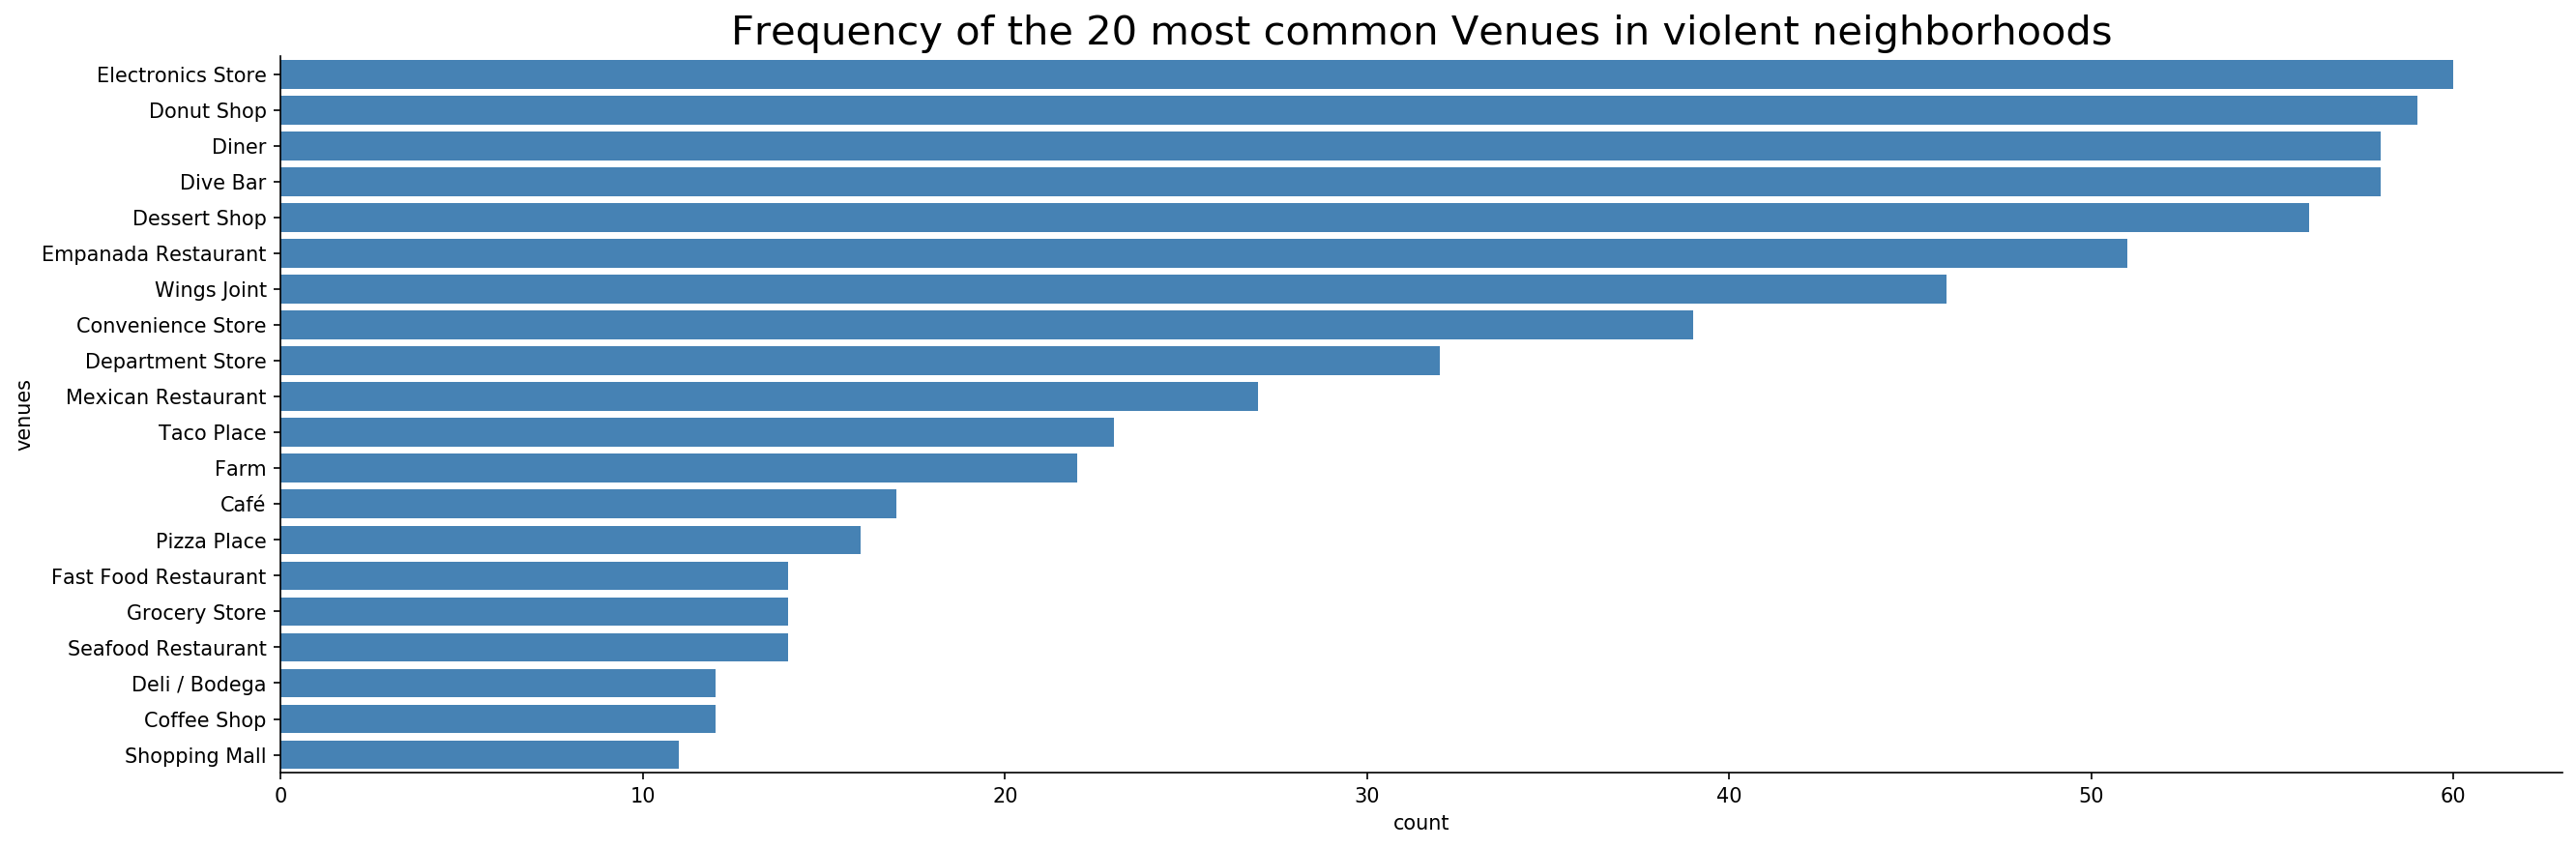

In [48]:
# create a count plot for all crime scene locations
g = sns.catplot(x='count',
                   y='venues',
                   data=venues_count,
                   kind='bar',
                   height=10,
                   orient = 'h',
                   color='steelblue', 
                   saturation=10)
g.fig.set_size_inches(20,6)
#g.set_xticklabels(rotation=90)
plt.title("Frequency of the 20 most common Venues in violent neighborhoods", fontsize=20)
plt.subplots_adjust(top=0.88)
plt.savefig('common_venues.pdf', dpi = 500, bbox_inches='tight')
plt.show()

## Cluster Neighborhoods

Run *k*-means to cluster the neighborhood into 3 clusters.

In [49]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [51]:
# set number of clusters
kclusters = 3

tijuana_grouped_clustering = tijuana_grouped.drop('NEIGHBORHOOD_OF_THE_CRIME', 1)

# run k-means clustering
kmeans5 = KMeans(n_clusters=kclusters, random_state=0).fit(tijuana_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans5.labels_[0:10] 

array([1, 0, 1, 0, 1, 1, 0, 1, 1, 1], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [52]:
# add clustering labels
Neighborhood_venues_sorted.insert(0, 'Cluster Labels', kmeans5.labels_)

tijuana_merged = NEIGHBORHOOD_MORE_VIOLENT

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
tijuana_merged = tijuana_merged.join(Neighborhood_venues_sorted.set_index('NEIGHBORHOOD_OF_THE_CRIME'), on='NEIGHBORHOOD_OF_THE_CRIME')

In [53]:
tijuana_merged.head()

,NEIGHBORHOOD_OF_THE_CRIME,counts,ADDRESS,location,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ZONA CENTRO,1502,"ZONA CENTRO,Tijuana,Mexico","Zona Centro, Tijuana, Municipio de Tijuana, Ba...",32.532928,-117.036843,1.0,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery
1,MARIANO MATAMOROS,1033,"MARIANO MATAMOROS,Tijuana,Mexico","Mariano Matamoros, SN, Calle Alicante, Otay Co...",32.513355,-116.945469,1.0,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
2,ZONA URBANA RIO TIJUANA,863,"ZONA URBANA RIO TIJUANA,Tijuana,Mexico","Zona Urbana Río Tijuana, Tijuana, Municipio de...",32.529637,-117.019868,1.0,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum
3,CAMINO VERDE,544,"CAMINO VERDE,Tijuana,Mexico","Mexico, SN, Avenida Melchor Ocampo, Ejido Mata...",32.516067,-116.858502,0.0,Convenience Store,Restaurant,Diner,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Dessert Shop,Wings Joint
4,MARIANO MATAMOROS NORTE,500,"MARIANO MATAMOROS NORTE,Tijuana,Mexico","Mariano Matamoros, SN, Calle Alicante, Otay Co...",32.513355,-116.945469,1.0,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop


Check for NaN values

In [54]:
tijuana_merged = tijuana_merged.drop(tijuana_merged.columns[[3]], axis=1) 

In [55]:
NaNs = tijuana_merged[tijuana_merged.isna().any(axis=1)]

In [56]:
NaNs.head()

,NEIGHBORHOOD_OF_THE_CRIME,counts,ADDRESS,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,EL RUBI,357,"EL RUBI,Tijuana,Mexico",32.499150,-117.059647,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,20 DE NOVIEMBRE,273,"20 DE NOVIEMBRE,Tijuana,Mexico",32.462901,-116.946691,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,FRACC HCDA LAS DELICIAS,268,"FRACC HCDA LAS DELICIAS,Tijuana,Mexico",32.407000,-116.941100,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,TERRAZAS DEL VALLE,264,"TERRAZAS DEL VALLE,Tijuana,Mexico",32.488554,-116.826424,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,ANEXA LOMA DORADA,244,"ANEXA LOMA DORADA,Tijuana,Mexico",32.465100,-116.946600,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [57]:
NaNs = NaNs.drop(NaNs.columns[[2,3,4,5,6,7]], axis=1) 

In [58]:
NaNs

,NEIGHBORHOOD_OF_THE_CRIME,counts,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,EL RUBI,357,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,20 DE NOVIEMBRE,273,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25,FRACC HCDA LAS DELICIAS,268,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
26,TERRAZAS DEL VALLE,264,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
31,ANEXA LOMA DORADA,244,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
32,PEDREGAL DE SANTA JULIA,231,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
33,ALTIPLANO,226,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
40,10 DE MAYO,197,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
42,3 DE OCTUBRE,195,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
46,VALLE VERDE,181,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [59]:
tijuana_merged.head(2)

,NEIGHBORHOOD_OF_THE_CRIME,counts,ADDRESS,latitude,longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ZONA CENTRO,1502,"ZONA CENTRO,Tijuana,Mexico",32.532928,-117.036843,1.0,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery
1,MARIANO MATAMOROS,1033,"MARIANO MATAMOROS,Tijuana,Mexico",32.513355,-116.945469,1.0,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop


## Eliminate the missing data

In [60]:
missing_data = tijuana_merged.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

NEIGHBORHOOD_OF_THE_CRIME
False    100
Name: NEIGHBORHOOD_OF_THE_CRIME, dtype: int64

counts
False    100
Name: counts, dtype: int64

ADDRESS
False    100
Name: ADDRESS, dtype: int64

latitude
False    100
Name: latitude, dtype: int64

longitude
False    100
Name: longitude, dtype: int64

Cluster Labels
False    82
True     18
Name: Cluster Labels, dtype: int64

1st Most Common Venue
False    82
True     18
Name: 1st Most Common Venue, dtype: int64

2nd Most Common Venue
False    82
True     18
Name: 2nd Most Common Venue, dtype: int64

3rd Most Common Venue
False    82
True     18
Name: 3rd Most Common Venue, dtype: int64

4th Most Common Venue
False    82
True     18
Name: 4th Most Common Venue, dtype: int64

5th Most Common Venue
False    82
True     18
Name: 5th Most Common Venue, dtype: int64

6th Most Common Venue
False    82
True     18
Name: 6th Most Common Venue, dtype: int64

7th Most Common Venue
False    82
True     18
Name: 7th Most Common Venue, dtype: int64

8th Most Com

In [61]:
tijuana_merged.dropna(subset=["Cluster Labels"], axis=0, inplace=True)

In [62]:
missing_data = tijuana_merged.isnull()
for column in missing_data.columns.values.tolist():
    print(column)
    print (missing_data[column].value_counts())
    print("") 

NEIGHBORHOOD_OF_THE_CRIME
False    82
Name: NEIGHBORHOOD_OF_THE_CRIME, dtype: int64

counts
False    82
Name: counts, dtype: int64

ADDRESS
False    82
Name: ADDRESS, dtype: int64

latitude
False    82
Name: latitude, dtype: int64

longitude
False    82
Name: longitude, dtype: int64

Cluster Labels
False    82
Name: Cluster Labels, dtype: int64

1st Most Common Venue
False    82
Name: 1st Most Common Venue, dtype: int64

2nd Most Common Venue
False    82
Name: 2nd Most Common Venue, dtype: int64

3rd Most Common Venue
False    82
Name: 3rd Most Common Venue, dtype: int64

4th Most Common Venue
False    82
Name: 4th Most Common Venue, dtype: int64

5th Most Common Venue
False    82
Name: 5th Most Common Venue, dtype: int64

6th Most Common Venue
False    82
Name: 6th Most Common Venue, dtype: int64

7th Most Common Venue
False    82
Name: 7th Most Common Venue, dtype: int64

8th Most Common Venue
False    82
Name: 8th Most Common Venue, dtype: int64

9th Most Common Venue
False    82
Na

In [64]:
tijuana_merged['Cluster Labels'] =tijuana_merged['Cluster Labels'].astype(int)

## Finally, let's visualize the resulting clusters

In [65]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [67]:
# create map
map_clusters = folium.Map(location=[32.5149,-117.0382], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(tijuana_merged['latitude'], tijuana_merged['longitude'], tijuana_merged['NEIGHBORHOOD_OF_THE_CRIME'], tijuana_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
map_clusters.save('Venues_Clusters_Tijuana.html')       
map_clusters

In [69]:
tijuana_merged.loc[tijuana_merged['Cluster Labels'] == 0, tijuana_merged.columns[[1] + list(range(5, tijuana_merged.shape[1]))]]

,counts,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,544,0,Convenience Store,Restaurant,Diner,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Dessert Shop,Wings Joint
15,333,0,Convenience Store,Mexican Restaurant,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
17,325,0,Pharmacy,Café,Convenience Store,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
24,270,0,Convenience Store,Restaurant,Soccer Field,Baseball Field,Wings Joint,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
27,264,0,Taco Place,Coffee Shop,Convenience Store,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
28,257,0,Convenience Store,BBQ Joint,Grocery Store,Mexican Restaurant,Wings Joint,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
37,203,0,Taco Place,Coffee Shop,Convenience Store,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
39,199,0,Farm,Grocery Store,Paper / Office Supplies Store,Convenience Store,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner
41,196,0,Grocery Store,Food & Drink Shop,Convenience Store,Shopping Mall,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar
52,162,0,Convenience Store,Pharmacy,Food Court,Coffee Shop,Restaurant,Seafood Restaurant,Paper / Office Supplies Store,Warehouse Store,Gas Station,Dive Bar


In [71]:
tijuana_merged.loc[tijuana_merged['Cluster Labels'] == 1, tijuana_merged.columns[[1] + list(range(5, tijuana_merged.shape[1]))]]

,counts,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,1502,1,Bar,Mexican Restaurant,Convenience Store,Cocktail Bar,Beer Bar,Coffee Shop,Restaurant,Shopping Mall,Pizza Place,Brewery
1,1033,1,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
2,863,1,Bar,Brewery,Café,Movie Theater,Pharmacy,Pizza Place,Mexican Restaurant,Restaurant,Coffee Shop,Museum
4,500,1,Food & Drink Shop,Garden Center,Wings Joint,Fast Food Restaurant,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
5,496,1,Mexican Restaurant,Pizza Place,Café,Wings Joint,Department Store,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop
6,491,1,Pharmacy,Rental Car Location,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Deli / Bodega
7,476,1,Restaurant,Taco Place,Seafood Restaurant,Shopping Mall,Pizza Place,Mexican Restaurant,Burger Joint,Brazilian Restaurant,Sandwich Place,Japanese Restaurant
8,471,1,Taco Place,Pool,Gastropub,Deli / Bodega,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Department Store
9,436,1,Mexican Restaurant,Fast Food Restaurant,Wings Joint,Dessert Shop,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
10,392,1,Taco Place,Department Store,Mexican Restaurant,Supermarket,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Wings Joint


In [73]:
tijuana_merged.loc[tijuana_merged['Cluster Labels'] == 2, tijuana_merged.columns[[1] + list(range(5, tijuana_merged.shape[1]))]]

,counts,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
13,367,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
50,167,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
53,160,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
56,155,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
67,139,2,Convenience Store,Pizza Place,Department Store,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Dessert Shop,Deli / Bodega
83,110,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
94,101,2,Convenience Store,Wings Joint,Dessert Shop,Farm,Empanada Restaurant,Electronics Store,Donut Shop,Dive Bar,Diner,Department Store
